In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
import scipy.stats as stats
from sklearn.metrics import roc_auc_score,auc,roc_curve

In [2]:
#Import dữ liệu đã được tiền xử lý
df = pd.read_csv('../../../BankChurners_Preprocessing.csv')

## Chọn Attrition_Flag làm thuộc tính quyết định. Nhưng vì Attrition_Flag đang bị mất cân bằng dữ liệu. Vậy nên ta cần xử lí mất cân bằng trước

Tách dữ liệu thành 2 phần. 1 phần chứa các cột còn lại và cột chứa thuộc tính quyết định.
features: Chứa các thuộc tính còn lại.
labels: Chứa thuộc tính quyết định.

In [3]:
features=df.drop('Attrition_Flag',axis=1)
labels=df['Attrition_Flag']

Chuyển đổi các cột không phải dạng số trong biến features về dạng one-hot vector

In [4]:
features_onehot=pd.get_dummies(features,columns=features.select_dtypes(exclude=['int64']).columns)

In [5]:
#Chia tập dữ liệu theo train 80%, test 20%
X_train, X_test, y_train, y_test = train_test_split(features_onehot, labels, test_size=0.2, random_state=42,shuffle=True)

In [6]:
# Áp dụng kỹ thuật Undersampling để làm cân bằng dữ liệu
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

In [7]:
print(y_train_resampled.shape)
print(X_train_resampled.shape)

(2600,)
(2600, 21)


In [8]:
clf = DecisionTreeClassifier(random_state=0)

In [9]:
params= {
    'max_depth': [int(x) for x in np.arange(start = 10, stop = 101, step = 10)],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto','sqrt','log2']
    }

In [10]:
clf_rd = RandomizedSearchCV(estimator=clf,
                    param_distributions = params,
                                   n_iter = 25,              
                                   refit = "recall",
                                   return_train_score = False,
                                   random_state = 0,
                                   cv = 3,
                                   n_jobs = -1)

In [11]:
clf_rd.fit(X_train_resampled, y_train_resampled)

c:\Users\diuai\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=0),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   random_state=0, refit='recall')

In [12]:
clf_rd.best_params_

{'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 30}

In [13]:
clf=DecisionTreeClassifier(criterion='entropy',
                           max_depth= 30, 
                           min_samples_leaf= 2,
                           min_samples_split=10,
                           max_features='auto')
clf.fit(X_train_resampled,y_train_resampled)

c:\Users\diuai\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


DecisionTreeClassifier(criterion='entropy', max_depth=30, max_features='auto',
                       min_samples_leaf=2, min_samples_split=10)

In [14]:
tree_pred = clf.predict(X_test)
tree_score=metrics.accuracy_score(y_test,tree_pred)
print("Accuracy:",tree_score)
print("Report:",metrics.classification_report(y_test,tree_pred))

Accuracy: 0.8346495557749259
Report:               precision    recall  f1-score   support

           0       0.49      0.85      0.62       327
           1       0.97      0.83      0.89      1699

    accuracy                           0.83      2026
   macro avg       0.73      0.84      0.76      2026
weighted avg       0.89      0.83      0.85      2026



In [15]:
tree_cm=metrics.confusion_matrix(y_test,tree_pred)

Text(0.5, 1.0, 'ID3 Accuracy Score : 0.8346495557749259')

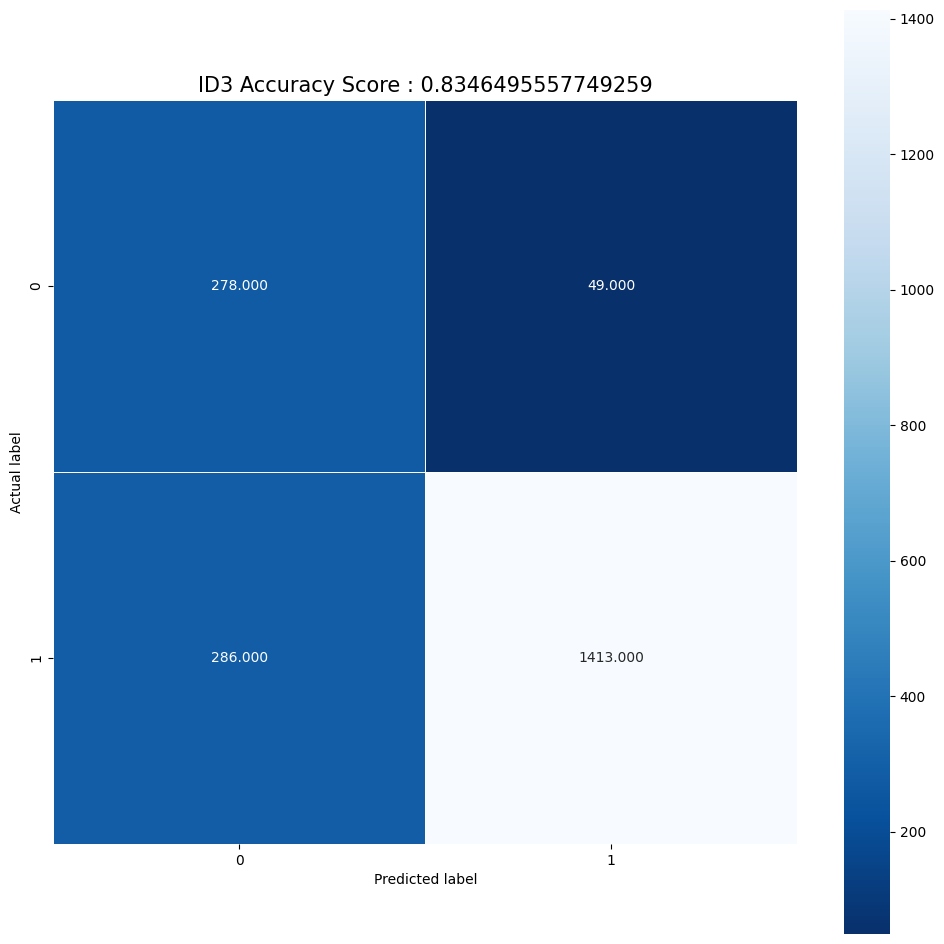

In [16]:
plt.figure(figsize=(12,12))
sns.heatmap(tree_cm,annot=True,fmt=".3f",linewidths=.5,square=True,cmap="Blues_r")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'ID3 Accuracy Score : {0}'.format(tree_score)
plt.title(title,size=15)

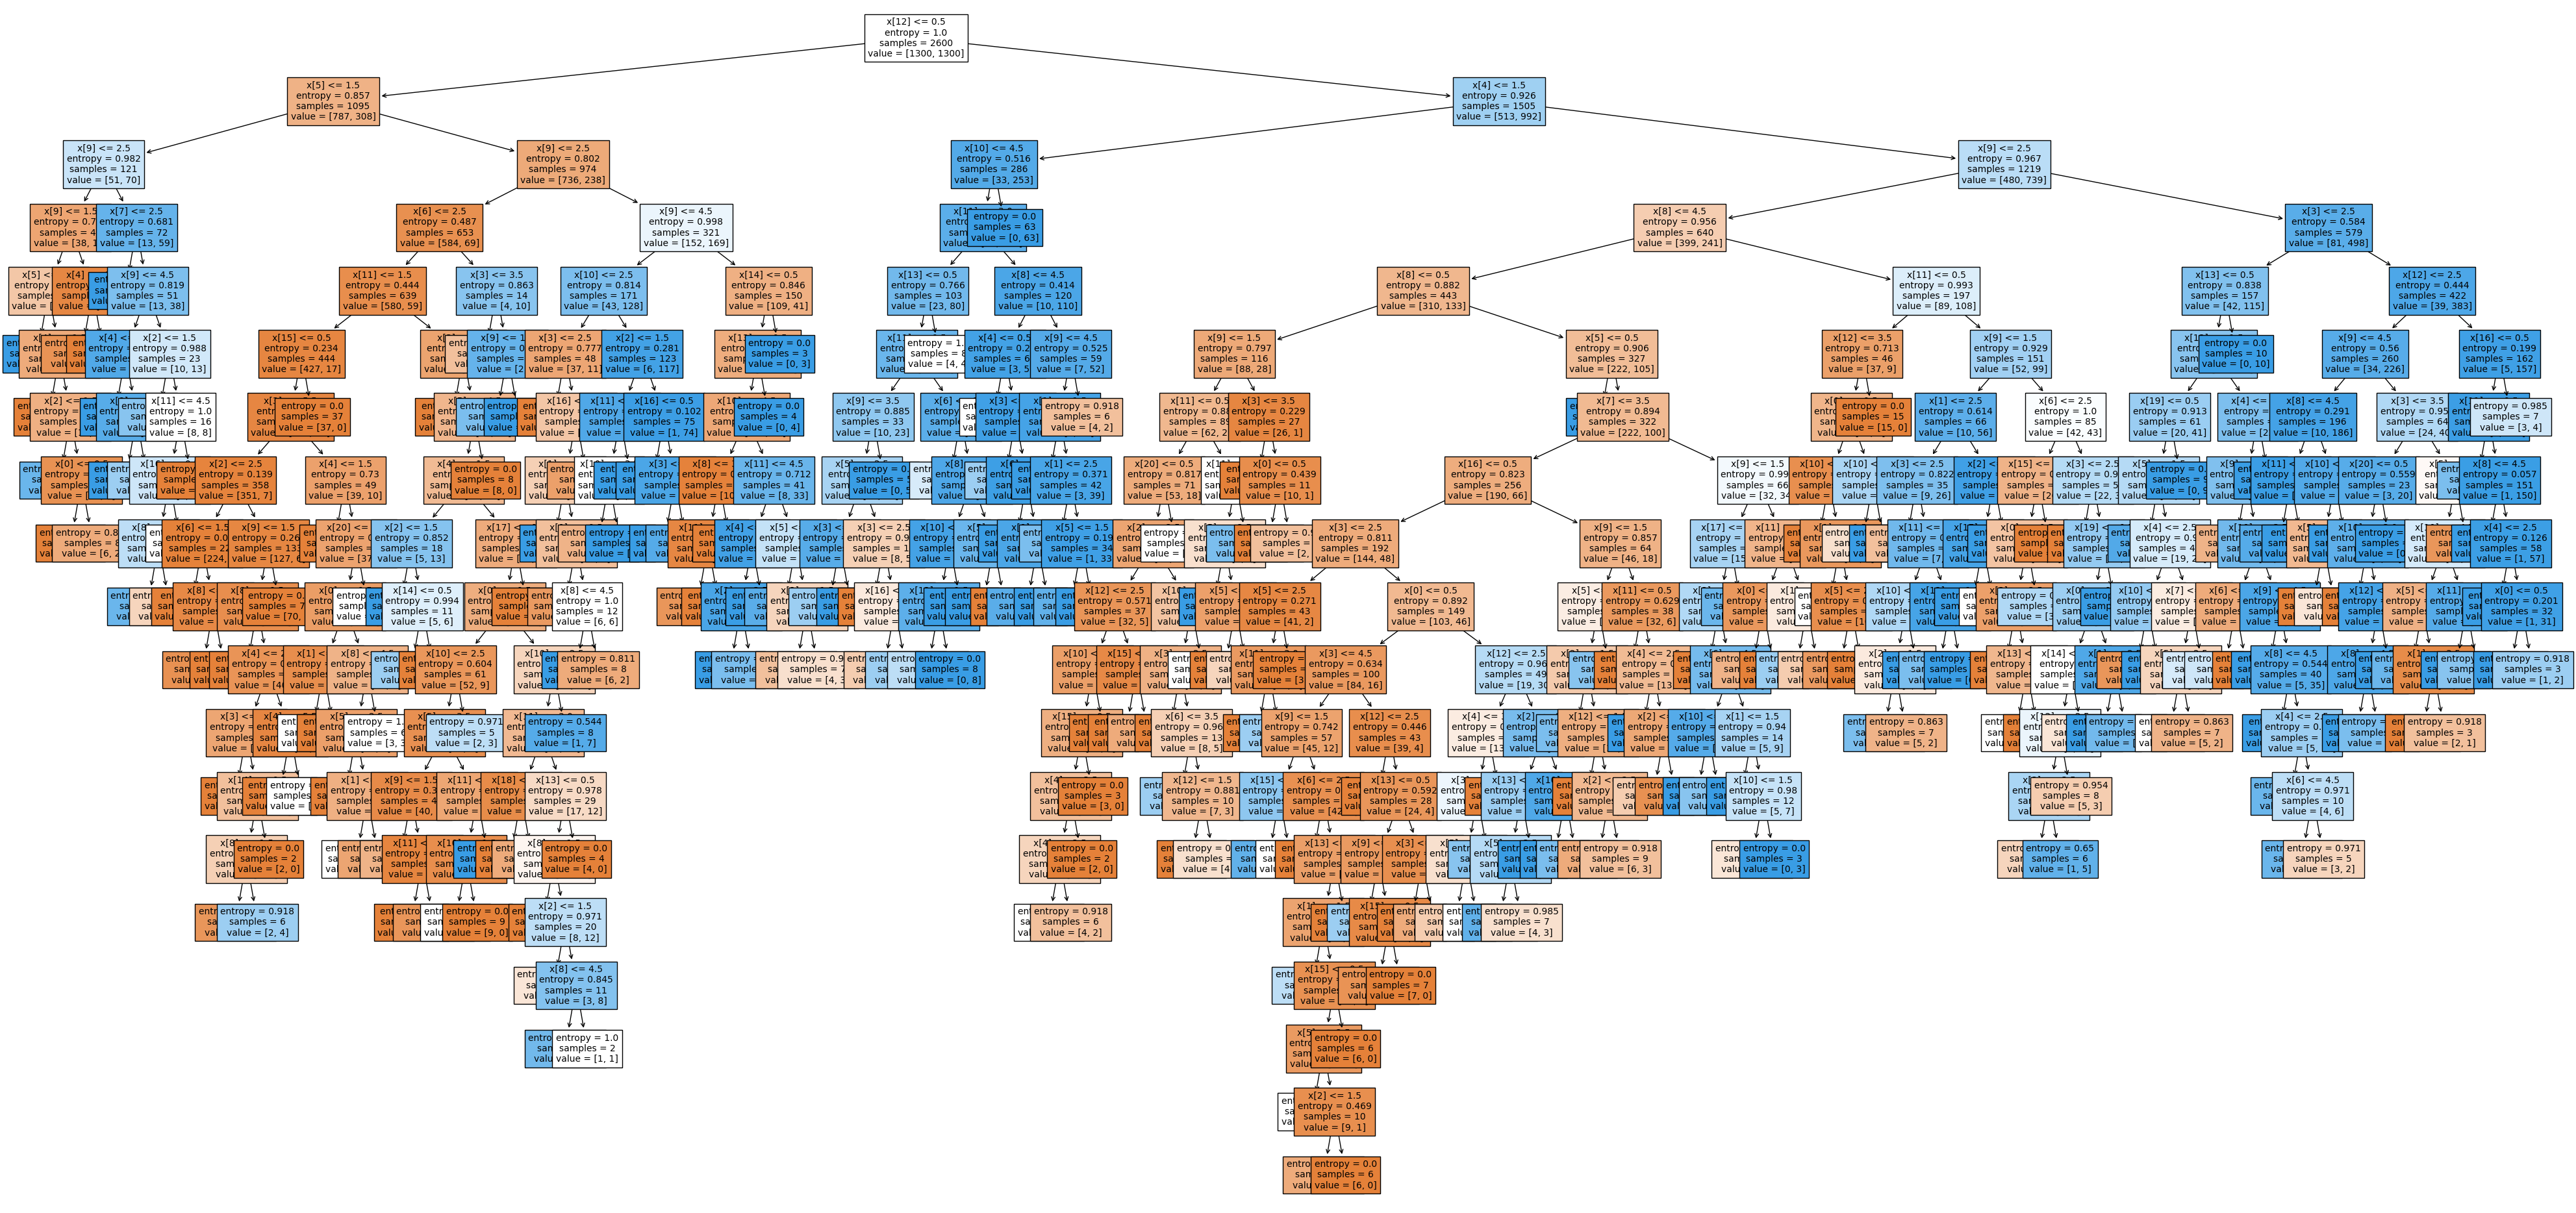

In [17]:
fig,ax=plt.subplots(figsize=(50,24))
tree.plot_tree(clf,filled=True,fontsize=10)
plt.savefig('decision tree',dpi=100)
plt.show()

## TÍNH ROC AUC

In [18]:
y_true=y_test
y_probas = clf.predict_proba(X_test)[:,1]

In [19]:
# Tính đường cong ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probas)
roc_auc = auc(fpr, tpr)

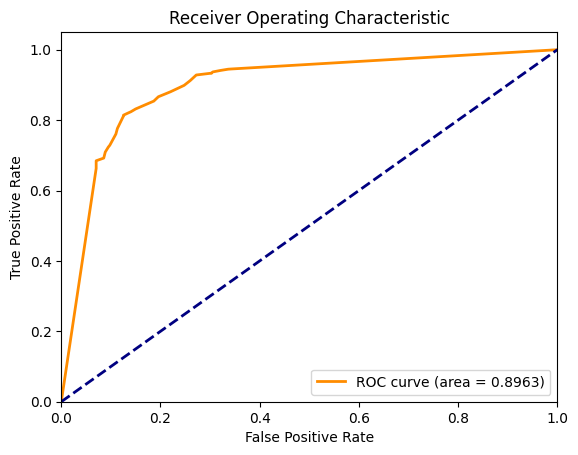

In [20]:
# Vẽ đường cong ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()